## 라이브러리

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, coo_matrix
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import RandomNodeSplit

## 데이터셋

In [3]:
def generate_graph_data(num_nodes=1000):
    np.random.seed(1127)
    torch.manual_seed(1127)
    
    # 비선형 데이터
    X = np.random.rand(num_nodes, 5)  # 5차원
    y = np.sin(X[:, 0] * 3) + 0.1 * np.random.rand(num_nodes)
    
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    
    # PyG 데이터 변환
    return Data(
        x = torch.tensor(X, dtype = torch.float32),
        edge_index= edge_index,
        y = torch.tensor(y, dtype = torch.float32).unsqueeze(1),
    )

def generate_noisy_graph_data(num_nodes=1000, noise_type="gaussian", noise_level=0.1, outlier_ratio=0.05):
    """
    다양한 노이즈를 추가하여 그래프 데이터를 생성하는 함수

    Args:
    - num_nodes (int): 노드 개수
    - noise_type (str): 추가할 노이즈 유형 ("gaussian", "uniform", "outlier", "edge_noise")
    - noise_level (float): 노이즈의 강도 (가우시안 및 유니폼 노이즈)
    - outlier_ratio (float): 이상치(outlier) 비율

    Returns:
    - PyG Data 객체
    """
    np.random.seed(1127)
    torch.manual_seed(1127)
    
    X = np.random.rand(num_nodes, 5)  # 5차원 특징
    y = np.sin(X[:, 0] * 3) + 0.1 * np.random.rand(num_nodes)  # 기본 타겟
    
    if noise_type == "gaussian":
        y += np.random.normal(0, noise_level, size=num_nodes)
    elif noise_type == "uniform":
        y += np.random.uniform(-noise_level, noise_level, size=num_nodes)
    elif noise_type == "outlier":
        num_outliers = int(num_nodes * outlier_ratio)
        outlier_indices = np.random.choice(num_nodes, num_outliers, replace=False)
        y[outlier_indices] += np.random.normal(3, 1.0, size=num_outliers)  # 극단적인 변화

    # 그래프 구조적 노이즈 (엣지 변경)
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    if noise_type == "edge_noise":
        # 엣지에 무작위 잡음을 추가하여 구조적 변형 수행
        num_noisy_edges = int(edge_index.shape[1] * noise_level)
        noise_indices = np.random.choice(edge_index.shape[1], num_noisy_edges, replace=False)
        edge_index[:, noise_indices] = torch.randint(0, num_nodes, (2, num_noisy_edges))

    return Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.float32).unsqueeze(1),
    )

def max_normalize(x):
    return x / np.max(np.abs(x)) if np.max(np.abs(x)) != 0 else x

def std_normalize(x):
    return (x - np.mean(x)) / np.std(x) if np.std(x) != 0 else np.zeros(len(x))

def int_normalize(x):
    return ((x - np.min(x)) / (np.max(x) - np.min(x)) * 2 - 1) if np.std(x) != 0 else np.zeros(len(x))

def simulate_ising(n, h0, J):
    G = nx.grid_2d_graph(n, n)
    l = np.linspace(-1.0, 1.0, n)
    
    s = np.random.choice([-1, 1], size=(n, n))
    # Placeholder for metropolis algorithm
    y = s.flatten()
    f = [[l[i], l[j]] for j in range(n) for i in range(n)]
    
    return G, [nx.to_scipy_sparse_matrix(G)], y, f

def parse_mean_fill(series, normalize=False):
    series = series.replace({',': ''}, regex=True)
    series = pd.to_numeric(series, errors='coerce')
    mean_val = series.mean()
    series.fillna(mean_val, inplace=True)
    
    if normalize:
        series = (series - mean_val) / series.std()
    
    return series.values

def read_county(prediction, year):
    adj = pd.read_csv("dataset/election/adjacency.txt", header=None, sep="\t", dtype=str, encoding="ISO-8859-1")
    fips2cty = {row[1]: row[0] for _, row in adj.iterrows() if pd.notna(row[1])}
    
    hh = adj.iloc[:, 1].ffill().astype(int)
    tt = adj.iloc[:, 3].astype(int)
    
    fips = sorted(set(hh).union(set(tt)))
    id2num = {id_: num for num, id_ in enumerate(fips)}
    
    G = nx.Graph()
    G.add_nodes_from(range(len(id2num)))
    G.add_edges_from([(id2num[h], id2num[t]) for h, t in zip(hh, tt)])
    
    # Load datasets
    VOT = pd.read_csv("dataset/election/election.csv")
    ICM = pd.read_csv("dataset/election/income.csv")
    POP = pd.read_csv("dataset/election/population.csv")
    EDU = pd.read_csv("dataset/election/education.csv")
    UEP = pd.read_csv("dataset/election/unemployment.csv")
    
    cty = pd.DataFrame({'FIPS': fips, 'County': [fips2cty.get(f, '') for f in fips]})
    vot = VOT[['fips_code', f'dem_{year}', f'gop_{year}']].rename(columns={'fips_code': 'FIPS'})
    icm = ICM[['FIPS', f'MedianIncome{min(max(2011, year), 2018)}']]
    pop = POP[['FIPS', f'R_NET_MIG_{min(max(2011, year), 2018)}', f'R_birth_{min(max(2011, year), 2018)}', f'R_death_{min(max(2011, year), 2018)}']]
    edu = EDU[['FIPS', f'BachelorRate{year}']]
    uep = UEP[['FIPS', f'Unemployment_rate_{min(max(2007, year), 2018)}']]
    
    dat = cty.merge(vot, on='FIPS', how='left')
    dat = dat.merge(icm, on='FIPS', how='left')
    dat = dat.merge(pop, on='FIPS', how='left')
    dat = dat.merge(edu, on='FIPS', how='left')
    dat = dat.merge(uep, on='FIPS', how='left')
    
    # Extract features and labels
    dem = parse_mean_fill(dat.iloc[:, 2])
    gop = parse_mean_fill(dat.iloc[:, 3])
    
    ff = np.zeros((len(dat), 7), dtype=np.float32)
    for i in range(6):
        ff[:, i] = parse_mean_fill(dat.iloc[:, i + 4], normalize=True)
    
    ff[:, 6] = (gop - dem) / (gop + dem)
    
    label_mapping = {
        "income": 0, "migration": 1, "birth": 2, "death": 3,
        "education": 4, "unemployment": 5, "election": 6
    }
    
    if prediction not in label_mapping:
        raise ValueError("Unexpected prediction type")
    
    pos = label_mapping[prediction]
    y = ff[:, pos]
    f = [np.concatenate((ff[i, :pos], ff[i, pos + 1:])) for i in range(len(dat))]
    
    return G, [csr_matrix(nx.adjacency_matrix(G))], y, f

def load_county_graph_data(prediction: str, year: int):
    G, A, labels, feats = read_county(prediction, year)

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def read_transportation_network(network_name, net_skips, net_cols, netf_cols, flow_skips, flow_cols, V_range):
    # Load data
    dat_net = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_net.tntp", 
                           skiprows=net_skips, sep='\s+', usecols=net_cols, header=None).values
    dat_netf = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_net.tntp", 
                            skiprows=net_skips, sep='\s+', usecols=netf_cols, header=None).values
    dat_flow = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_flow.tntp", 
                            skiprows=flow_skips, sep='\s+', usecols=flow_cols, header=None).values
    
    # Map node labels to indices
    lb2id = {v: i for i, v in enumerate(V_range, start=1)}
    NV = len(V_range)
    
    # Create directed graph
    g = nx.DiGraph()
    g.add_nodes_from(range(1, NV + 1))
    
    for src, dst in dat_net:
        if src in lb2id and dst in lb2id:
            g.add_edge(lb2id[src], lb2id[dst])
    
    # Edge labels
    flow_dict = {}
    for src, dst, flow in dat_flow:
        if src in lb2id and dst in lb2id:
            flow_dict[(lb2id[src], lb2id[dst])] = flow
    
    y = np.array([flow_dict.get((e[0], e[1]), 0) for e in g.edges()])
    y = (y - np.mean(y)) / np.std(y)  # Standard normalization
    
    # Edge features
    netf_dict = {}
    for i in range(len(dat_net)):
        src, dst = dat_net[i]
        if src in lb2id and dst in lb2id:
            netf_dict[(lb2id[src], lb2id[dst])] = dat_netf[i]
    
    ff = np.array([netf_dict[e] for e in g.edges()])
    mean_ff = np.mean(ff, axis=0)
    std_ff = np.std(ff, axis=0)
    std_ff[std_ff == 0] = 1  # Prevent division by zero
    netf = (ff - mean_ff) / std_ff  
    
    f = list(netf)
    
    # Line graph transformation
    G1 = nx.Graph()
    G2 = nx.Graph()
    sorted_edges = sorted(g.edges())
    tuple2id = {e: i for i, e in enumerate(sorted_edges)}
    
    for u in g.nodes:
        innbrs = list(g.predecessors(u))
        outnbrs = list(g.successors(u))
        
        for v in innbrs:
            for w in outnbrs:
                if (v, u) in tuple2id and (u, w) in tuple2id:
                    G1.add_edge(tuple2id[(v, u)], tuple2id[(u, w)])
        
        for v in innbrs:
            for w in innbrs:
                if w > v and (v, u) in tuple2id and (w, u) in tuple2id:
                    G2.add_edge(tuple2id[(v, u)], tuple2id[(w, u)])
        
        for v in outnbrs:
            for w in outnbrs:
                if w > v and (u, v) in tuple2id and (u, w) in tuple2id:
                    G2.add_edge(tuple2id[(u, v)], tuple2id[(u, w)])
                    
    size = max(len(G1.nodes), len(G2.nodes))
    A1 = np.zeros((size, size))
    A2 = np.zeros((size, size))
    
    A1[:nx.number_of_nodes(G1), :nx.number_of_nodes(G1)] = nx.adjacency_matrix(G1).todense()
    A2[:nx.number_of_nodes(G2), :nx.number_of_nodes(G2)] = nx.adjacency_matrix(G2).todense()
    
    A = A1 + A2
    
    return nx.Graph(A), A, y, f

def load_trans_graph_data(city: str):
    if city == 'Anaheim':
        G, A, labels, feats = read_transportation_network(city, 8, [0, 1], [2, 3, 4, 7], 6, [0, 1, 3], range(1, 417))
    elif city == 'ChicagoSketch':
        G, A, labels, feats = read_transportation_network(city, 7, [0, 1], [2, 3, 4, 7], 1, [0, 1, 2], range(388, 934))

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def read_twitch_network(cnm, dim_reduction=False, dim_embed=8):
    feats_all = []
    countries = ["DE", "ENGB", "ES", "FR", "PTBR", "RU"]
    
    for cn in countries:
        with open(f"dataset/twitch/{cn}/musae_{cn}_features.json", "r") as f:
            feats = json.load(f)
        feats_all.extend(feats.values())

    ndim = max(np.concatenate(feats_all)) + 1

    def feat_encode(feat_list):
        """특징 벡터를 원핫 인코딩 형태로 변환"""
        vv = np.zeros(ndim, dtype=np.float32)
        valid_indices = np.array(feat_list)
        
        if np.any(valid_indices >= ndim):
            raise ValueError(f"Index out of bounds! Max index: {max(valid_indices)}, ndim: {ndim}")
        
        vv[valid_indices] = 1.0
        return vv

    f_all = list(map(feat_encode, feats_all))

    with open(f"dataset/twitch/{cnm}/musae_{cnm}_features.json", "r") as f:
        feats = json.load(f)

    id2ft = {int(k) + 1: v for k, v in feats.items()}
    n = len(id2ft)
    assert min(id2ft.keys()) == 1 and max(id2ft.keys()) == n

    f = [feat_encode(id2ft[i]) for i in sorted(id2ft.keys())]

    if dim_reduction:
        f_matrix = np.stack(f_all, axis=1)
        U, S, Vt = svds(f_matrix, k=dim_embed)
        U *= np.sign(np.sum(U, axis=0))  # sign correction
        f = [U.T @ f_ for f_ in f]

    g = nx.Graph()
    g.add_nodes_from(range(1, len(f) + 1))

    links = pd.read_csv(f"dataset/twitch/{cnm}/musae_{cnm}_edges.csv")
    for _, row in links.iterrows():
        g.add_edge(row["from"] + 1, row["to"] + 1)

    trgts = pd.read_csv(f"dataset/twitch/{cnm}/musae_{cnm}_target.csv")
    nid2views = dict(zip(trgts["new_id"], trgts["views"]))
    y = std_normalize(np.log([nid2views[i - 1] + 1.0 for i in range(1, g.number_of_nodes() + 1)]))

    return g, [csr_matrix(nx.adjacency_matrix(g))], y, f

def load_twitch_graph_data(cnm: str):
    G, A, labels, feats = read_twitch_network(cnm)

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def load_wiki_graph_data(category):
    edge_path = f'dataset/wikipedia/{category}/musae_{category}_edges.csv'
    feature_path = f'dataset/wikipedia/{category}/musae_{category}_features.json'
    target_path = f'dataset/wikipedia/{category}/musae_{category}_target.csv'
    
    # 엣지 데이터 로드
    edge_df = pd.read_csv(edge_path)
    edge_index = torch.tensor(edge_df.values.T, dtype=torch.long)
    
    # 피처 데이터 로드
    with open(feature_path, "r") as f:
        features_dict = json.load(f)
    
    node_ids = sorted(map(int, features_dict.keys()))  # 노드 ID 정렬
    node_id_map = {old_id: new_id for new_id, old_id in enumerate(node_ids)}
    
    num_nodes = len(node_ids)
    num_features = max(max(v) for v in features_dict.values()) + 1  # 가장 큰 feature index 찾기
    x = torch.zeros((num_nodes, num_features), dtype=torch.float32)
    
    for node, features in features_dict.items():
        new_id = node_id_map[int(node)]  # 노드 ID 변환
        x[new_id, features] = 1.0  # One-hot 인코딩
    
    # 타겟 데이터 로드
    target_df = pd.read_csv(target_path)
    target_df["id"] = target_df["id"].map(node_id_map)  # 노드 ID 변환
    target_df = target_df.dropna().astype(int)  # 변환되지 않은 노드 제거
    
    # y = torch.zeros(num_nodes, dtype=torch.long)
    y = torch.zeros((num_nodes, 1), dtype=torch.long)  # [, 1] 형태로 변경
    y[target_df["id"].values] = torch.tensor(target_df["target"].values, dtype=torch.long).view(-1, 1)
    
    # PyG Data 객체 생성
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    return graph_data

In [4]:
# 기본 비선형 그래프 데이터
graph_data_basic = generate_graph_data(num_nodes=1000)

# 노이즈 비선형 그래프 데이터
graph_data_noise_gaussian = generate_noisy_graph_data(num_nodes=1000, noise_type='gaussian', noise_level=0.2)
graph_data_noise_uniform = generate_noisy_graph_data(num_nodes=1000, noise_type='uniform', noise_level=0.2)
graph_data_noise_outlier = generate_noisy_graph_data(num_nodes=1000, noise_type='outlier', noise_level=0.2)
graph_data_noise_edge = generate_noisy_graph_data(num_nodes=1000, noise_type='edge_noise', noise_level=0.2)

# County 데이터셋
graph_data_county_edu = load_county_graph_data('education', 2012)
graph_data_county_elec = load_county_graph_data('election', 2012)
graph_data_county_inc = load_county_graph_data('income', 2012)
graph_data_county_unemp = load_county_graph_data('unemployment', 2012)

# Twitch 데이터셋
graph_data_twitch_de = load_twitch_graph_data('DE')
graph_data_twitch_engb = load_twitch_graph_data('ENGB')
graph_data_twitch_es = load_twitch_graph_data('ES')
graph_data_twitch_fr = load_twitch_graph_data('FR')
graph_data_twitch_ptbr = load_twitch_graph_data('PTBR')
graph_data_twitch_ru = load_twitch_graph_data('RU')

# Wikipedia 데이터
graph_data_wiki_ch = load_wiki_graph_data('chameleon')
graph_data_wiki_cr = load_wiki_graph_data('crocodile')
graph_data_wiki_sq = load_wiki_graph_data('squirrel')

# Transfortation 데이터셋
graph_data_trans_ana = load_trans_graph_data('Anaheim')
graph_data_trans_chica = load_trans_graph_data('ChicagoSketch')

/tmp/ipykernel_2810674/3359291505.py:162: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  pyg_data.x = torch.tensor(feats, dtype=torch.float)


In [5]:
# 그래프 데이터 리스트 
graph_datasets = {
    "Basic": graph_data_basic,
    "Noise_Gaussian": graph_data_noise_gaussian,
    "Noise_Uniform": graph_data_noise_uniform,
    "Noise_Outlier": graph_data_noise_outlier,
    "Noise_Edge": graph_data_noise_edge,
    "County_Education": graph_data_county_edu,
    "County_Election": graph_data_county_elec,
    "County_Income": graph_data_county_inc,
    "County_Unemployment": graph_data_county_unemp,
    "Twitch_DE": graph_data_twitch_de,
    "Twitch_ENGB": graph_data_twitch_engb,
    "Twitch_ES": graph_data_twitch_es,
    "Twitch_FR": graph_data_twitch_fr,
    "Twitch_PTBR": graph_data_twitch_ptbr,
    "Twitch_RU": graph_data_twitch_ru,
    "Wikipedia_Chameleon": graph_data_wiki_ch,
    "Wikipedia_Crocodile": graph_data_wiki_cr,
    "Wikipedia_Squirrel": graph_data_wiki_sq,
    "Transportation_Anaheim": graph_data_trans_ana,
    "Transportation_Chicago": graph_data_trans_chica,
}

# 데이터 저장 리스트
graph_info_list = []

for dataset_name, graph_data in graph_datasets.items():
    if graph_data is None:
        continue  # 그래프 데이터가 없으면 스킵
    
    nodes = graph_data.x.shape[0] if hasattr(graph_data, "x") else 0  # 노드 개수
    edges = graph_data.edge_index.shape[1] if hasattr(graph_data, "edge_index") else 0  # 엣지 개수
    features = graph_data.x.shape[1] if hasattr(graph_data, "x") else 0  # 피처 개수
    
    graph_info_list.append({"Dataset": dataset_name, "Nodes": nodes, "Edges": edges, "Features": features})

# 데이터 프레임 생성
df_graph_info = pd.DataFrame(graph_info_list)
df_graph_info

,Dataset,Nodes,Edges,Features
0,Basic,1000,2000,5
1,Noise_Gaussian,1000,2000,5
2,Noise_Uniform,1000,2000,5
3,Noise_Outlier,1000,2000,5
4,Noise_Edge,1000,2000,5
5,County_Education,3234,12717,6
6,County_Election,3234,12717,6
7,County_Income,3234,12717,6
8,County_Unemployment,3234,12717,6
9,Twitch_DE,9498,153138,3170


## 모델 학습

In [9]:
def split_graph_data(graph_data, test_ratio=0.2):
    transform = RandomNodeSplit(split="train_rest", num_val=0.0, num_test=test_ratio)
    data = transform(graph_data)

    # Train/Test 마스크 생성
    train_mask = data.train_mask.to(data.x.device)
    test_mask = data.test_mask.to(data.x.device)

    # 훈련 및 테스트 데이터 선택
    train_data = data.clone()
    test_data = data.clone()

    train_data.x = data.x[train_mask]
    train_data.y = data.y[train_mask]
    test_data.x = data.x[test_mask]
    test_data.y = data.y[test_mask]

    # 노드 인덱스를 매핑하여 edge_index 수정 (훈련 데이터)
    train_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(train_mask.nonzero(as_tuple=True)[0])}
    train_edges_mask = train_mask[data.edge_index[0]] & train_mask[data.edge_index[1]]
    train_edges = data.edge_index[:, train_edges_mask]

    train_data.edge_index = torch.stack([
        torch.tensor([train_node_mapping[i.item()] for i in train_edges[0]], dtype=torch.long, device=data.x.device),
        torch.tensor([train_node_mapping[i.item()] for i in train_edges[1]], dtype=torch.long, device=data.x.device)
    ], dim=0)

    # 노드 인덱스를 매핑하여 edge_index 수정 (테스트 데이터)
    test_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(test_mask.nonzero(as_tuple=True)[0])}
    test_edges_mask = test_mask[data.edge_index[0]] & test_mask[data.edge_index[1]]
    test_edges = data.edge_index[:, test_edges_mask]

    test_data.edge_index = torch.stack([
        torch.tensor([test_node_mapping[i.item()] for i in test_edges[0]], dtype=torch.long, device=data.x.device),
        torch.tensor([test_node_mapping[i.item()] for i in test_edges[1]], dtype=torch.long, device=data.x.device)
    ], dim=0)

    print(f"Train data: {train_data.x.shape[0]} nodes, {train_data.edge_index.shape[1]} edges")
    print(f"Test data: {test_data.x.shape[0]} nodes, {test_data.edge_index.shape[1]} edges")
    
    return train_data, test_data

def augment_features(x, tau):
    if isinstance(tau, float):  # tau가 float이면 변환
        tau = torch.tensor([tau])
    
    tau = tau.view(-1, 1)
    tau_transformed = (tau - 0.5) * 12 # 분위수 값 변환: 학습 안정성 증가
    
    return torch.cat((x, tau_transformed.expand(x.size(0), -1)), dim = 1)

def coverage_loss(y_true, y_low, y_upper, target = 0.9):
    coverage_exp = ((y_true >= y_low) & (y_true <= y_upper)).float().mean()
    
    return (coverage_exp - target) ** 2

def dynamic_quantile_adjustment(tau_low, tau_upper, coverage, epoch, target=0.9, learning_rate=0.001, initial_min_gap=0.5):
    coverage_error = (coverage - target) ** 2  
    tau_adjustment = max(0.01, min(0.2, learning_rate * abs(coverage_error) * 2))

    # 분위수 업데이트
    tau_low_new = max(0.01, tau_low - tau_adjustment if coverage > target else tau_low + tau_adjustment)
    tau_upper_new = min(0.99, tau_upper + tau_adjustment if coverage > target else tau_upper - tau_adjustment)

    # 최소 간격 유지
    min_gap = max(0.01, initial_min_gap * (0.99 ** epoch))
    
    if tau_upper_new - tau_low_new < min_gap:
        tau_mid = (tau_low_new + tau_upper_new) / 2
        tau_low_new = max(0.01, tau_mid - min_gap / 2)
        tau_upper_new = min(0.99, tau_mid + min_gap / 2)

    return tau_low_new, tau_upper_new

class GQNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels = 1):
        super().__init__()
        self.conv1 = SAGEConv(in_channels + 1, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, tau):
        x = augment_features(x, tau)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        return self.fc(x)

class QRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y_true, tau):
        diff = y_true - y_pred
        loss = torch.where(diff > 0, tau * diff, (tau - 1) * diff)
        
        return torch.mean(loss) 

class GQNN_RQR(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels = 2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        
        # 분위수 교차 방지 (q1 ≤ q2 보장)
        q1, q2 = torch.unbind(x, dim=1)  # (num_nodes, 2) → q1, q2로 분리
        q1, q2 = torch.min(q1, q2), torch.max(q1, q2)  # 분위수 순서 보장
        
        return torch.stack([q1, q2], dim=1)

class RQRLoss(nn.Module):
    def __init__(self, target_coverage=0.9, lambda_factor=0.1):
        super(RQRLoss, self).__init__()
        self.alpha = target_coverage
        self.l = lambda_factor

    def forward(self, q1, q2, target):
        # 분위수 회귀 손실
        diff1 = target - q1
        diff2 = target - q2
        rqr_loss = torch.maximum(diff1 * diff2 * (self.alpha + 2 * self.l),
                                diff2 * diff1 * (self.alpha + 2 * self.l - 1))

        # 신뢰구간 너비 최소화 정규화
        width = q2 - q1
        width_loss = self.l * torch.square(width) * 0.5

        return torch.mean(rqr_loss + width_loss)
    
class CombinedRQRLoss(nn.Module):
    def __init__(self, target_coverage=0.9, lambda_factor=1.0, quantile_weight=1.0, coverage_weight=1.0):
        super(CombinedRQRLoss, self).__init__()
        self.target_coverage = target_coverage
        self.lambda_factor = lambda_factor
        self.quantile_weight = quantile_weight  # 분위수 손실 가중치
        self.coverage_weight = coverage_weight  # Coverage Loss 가중치

    def quantile_loss(self, y_pred, y_true, tau):
        """ 기존 QRLoss 활용 """
        diff = y_true - y_pred
        loss = torch.where(diff > 0, tau * diff, (tau - 1) * diff)
        return torch.mean(loss)

    def forward(self, q1, q2, target, tau_low=0.05, tau_upper=0.95):
        width = torch.relu(q2 - q1)

        # 분위수 회귀 손실
        quantile_loss_low = self.quantile_loss(q1, target, tau_low)
        quantile_loss_upper = self.quantile_loss(q2, target, tau_upper)
        quantile_loss = self.quantile_weight * (quantile_loss_low + quantile_loss_upper)

        # 신뢰구간 너비 최소화 정규화
        width_penalty = self.lambda_factor * width ** 2 * 0.5

        # Coverage Loss 추가
        coverage = ((target >= q1) & (target <= q2)).float().mean()
        coverage_loss = self.coverage_weight* ((coverage - self.target_coverage) ** 2)

        return torch.mean(quantile_loss + width_penalty + coverage_loss)

def train_fixed_gqnn(train_data, q='all', hidden_channels=64, num_epochs=1000, learning_rate=0.001, weight=1e-3):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    in_channels = train_data.x.shape[1]
    model = GQNN(in_channels=in_channels, hidden_channels=hidden_channels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = QRLoss()
    train_data = train_data.to(device)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        if q == "all":
            taus = torch.rand(train_data.x.size(0), 1, dtype=torch.float32, device=device)
        else:
            taus = torch.full((train_data.x.size(0), 1), q, dtype=torch.float32, device=device)

        preds = model(train_data.x, train_data.edge_index, taus)

        loss = criterion(preds, train_data.y, taus)

        loss.backward()
        optimizer.step()

        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    return model

def train_fixed2_gqnn(train_data, q='all', tau_low=0.05, tau_upper=0.95, target=0.9, hidden_channels=64, num_epochs=1000, learning_rate=0.001, weight=1e-3):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    in_channels = train_data.x.shape[1]
    model = GQNN(in_channels=in_channels, hidden_channels=hidden_channels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = QRLoss()
    train_data = train_data.to(device)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        if q == "all":
            taus_low = (torch.rand(train_data.x.size(0), 1) * (0.5 - tau_low) + tau_low).to(device)
            taus_upper = (torch.rand(train_data.x.size(0), 1) * (tau_upper - 0.5) + 0.5).to(device)
        elif q == 'single':
            taus_low = torch.full((train_data.x.size(0), 1), tau_low, device=device)
            taus_upper = torch.full((train_data.x.size(0), 1), tau_upper, device=device)

        preds_low = model(train_data.x, train_data.edge_index, taus_low)
        preds_upper = model(train_data.x, train_data.edge_index, taus_upper)
        
        loss_low = criterion(preds_low, train_data.y, taus_low)
        loss_upper = criterion(preds_upper, train_data.y, taus_upper)
        quantile_loss = loss_low + loss_upper
        
        # 신뢰구간 너비 최소화 정규화
        width = preds_upper - preds_low
        width_loss = width ** 2 * 0.5

        # Coverage Loss 추가
        true = train_data.y
        coverage = ((true >= preds_low) & (true <= preds_upper)).float().mean()
        coverage_loss =  ((coverage - target) ** 2)
        
        loss = (quantile_loss + width_loss + coverage_loss).mean()
        loss.backward()
        optimizer.step()

        # coverage = ((train_data.y >= preds_low) & (train_data.y <= preds_upper)).float().mean().item()
        # target_coverage = 0.9
        # tau_low, tau_upper = dynamic_quantile_adjustment(tau_low, tau_upper, coverage, epoch, target=target_coverage)
        
        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Coverage Erro: {coverage_loss:.4f}")

    return model

def train_dynamic_gqnn(train_data, q='all', tau_low=0.05, tau_upper=0.95, hidden_channels=64, num_epochs=1000, learning_rate=0.001, weight=1e-3):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    in_channels = train_data.x.shape[1]
    model = GQNN(in_channels=in_channels, hidden_channels=hidden_channels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = QRLoss()
    train_data = train_data.to(device)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        if q == "all":
            taus_low = (torch.rand(train_data.x.size(0), 1) * (0.5 - tau_low) + tau_low).to(device)
            taus_upper = (torch.rand(train_data.x.size(0), 1) * (tau_upper - 0.5) + 0.5).to(device)
        elif q == 'single':
            taus_low = torch.full((train_data.x.size(0), 1), tau_low, device=device)
            taus_upper = torch.full((train_data.x.size(0), 1), tau_upper, device=device)

        preds_low = model(train_data.x, train_data.edge_index, taus_low)
        preds_upper = model(train_data.x, train_data.edge_index, taus_upper)
        
        loss_low = criterion(preds_low, train_data.y, taus_low)
        loss_upper = criterion(preds_upper, train_data.y, taus_upper)
        loss = loss_low + loss_upper
        
        loss.backward()
        optimizer.step()

        coverage = ((train_data.y >= preds_low) & (train_data.y <= preds_upper)).float().mean().item()
        target_coverage = 0.9
        tau_low, tau_upper = dynamic_quantile_adjustment(tau_low, tau_upper, coverage, epoch, target=target_coverage)
        
        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Coverage Error: {target_coverage - coverage:.4f}, Taus: {tau_low, tau_upper}")

    return model, tau_low, tau_upper

def train_rqr_gqnn(train_data, hidden_channels=64, num_epochs=1000, learning_rate=0.001, weight=1e-3):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    in_channels = train_data.x.shape[1]
    model = GQNN_RQR(in_channels=in_channels, hidden_channels=hidden_channels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = RQRLoss()
    train_data = train_data.to(device)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        preds = model(train_data.x, train_data.edge_index)
        loss = criterion(preds[:, 0], preds[:, 1], train_data.y)
        
        loss.backward()
        optimizer.step()

        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    return model

def train_combined_rqr_gqnn(train_data, hidden_channels=64, num_epochs=1000, learning_rate=0.001, weight=1e-3):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    in_channels = train_data.x.shape[1]
    model = GQNN_RQR(in_channels=in_channels, hidden_channels=hidden_channels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = CombinedRQRLoss(target_coverage=0.9, lambda_factor=0.1, quantile_weight=1.0, coverage_weight=0.05)
    train_data = train_data.to(device)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        preds = model(train_data.x, train_data.edge_index)  # 예측값 (q1, q2)
        loss = criterion(preds[:, 0], preds[:, 1], train_data.y, tau_low=0.05, tau_upper=0.95)
        
        loss.backward()
        optimizer.step()

        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    return model

def test_sg_gqnn(model, test_data, tau=0.05):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    model.eval()
    test_data = test_data.to(device)
    tau = torch.full((test_data.x.size(0), 1), tau, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        test_preds = model(test_data.x, test_data.edge_index, tau)
        test_targets = test_data.y
            
    return test_preds.cpu().numpy(), test_targets.cpu().numpy()

def test_all_gqnn(model, test_data, tau_low=0.05, tau_upper=0.95):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    model.eval()
    test_data = test_data.to(device)
    tau_low = torch.full((test_data.x.size(0), 1), tau_low, dtype=torch.float32, device=device)
    tau_upper = torch.full((test_data.x.size(0), 1), tau_upper, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        test_low_preds = model(test_data.x, test_data.edge_index, tau_low)
        test_upper_preds = model(test_data.x, test_data.edge_index, tau_upper)
        test_targets = test_data.y
            
    return test_low_preds.cpu().numpy(), test_upper_preds.cpu().numpy(), test_targets.cpu().numpy()

def test_rqr_gqnn(model, test_data):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    model.eval() 
    test_data = test_data.to(device)

    with torch.no_grad(): 
        test_preds = model(test_data.x, test_data.edge_index)
        test_low_preds = test_preds[:, 0]
        test_upper_preds = test_preds[:, 1]
        test_targets = test_data.y

    return test_low_preds.cpu().numpy(), test_upper_preds.cpu().numpy(), test_targets.cpu().numpy()

def evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, coverage_target=0.9):

    q1 = test_low_preds            # 신뢰구간 하한
    q2 = test_upper_preds          # 신뢰구간 상한
    median_pred = (q1 + q2) / 2    # 신뢰구간 중앙값

    coverage = np.mean((test_targets >= q1) & (test_targets <= q2))
    interval_width = np.mean(q2 - q1)
    mae = np.mean(np.abs(median_pred - test_targets))
    sharpness = np.mean(np.square(q2 - q1))

    print(f"   - Coverage Rate: {coverage:.4f} (목표: {coverage_target})")
    print(f"   - Prediction Interval Width (PIW): {interval_width:.4f}")
    print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
    # print(f"   - Sharpness: {sharpness:.4f}")

    # return {
    #     "coverage": coverage,
    #     "interval_width": interval_width,
    #     "mae": mae,
    #     "sharpness": sharpness }

def evaluate_intervals(test_low_preds, test_upper_preds, test_targets, coverage_target=0.9):
    """
    예측 구간의 품질을 평가하는 다양한 지표 계산
    """
    if isinstance(test_low_preds, np.ndarray):
        test_low_preds = torch.as_tensor(test_low_preds)

    if isinstance(test_upper_preds, np.ndarray):
        test_upper_preds = torch.as_tensor(test_upper_preds)

    if isinstance(test_targets, np.ndarray):
        test_targets = torch.as_tensor(test_targets)

    # 신뢰 구간 크기 (Mean Prediction Interval Width)
    MPIW = torch.mean(test_upper_preds - test_low_preds).item()
    
    # Coverage 계산 (PICP)
    coverage = ((test_targets >= test_low_preds) & (test_targets <= test_upper_preds)).float().mean().item()

    # 조정된 Coverage Tradeoff 지표 (MCT)
    MCT = MPIW * abs(coverage - coverage_target)

    # 정규화된 예측 구간 폭 (PINAW)
    PINAW = MPIW / (test_targets.max().item() - test_targets.min().item())

    print(f"Coverage (PICP): {coverage:.4f}")
    print(f"Mean Prediction Interval Width (MPIW): {MPIW:.4f}")
    print(f"MCT (Coverage-Width Tradeoff): {MCT:.4f}")
    print(f"PINAW (Normalized Interval Width): {PINAW:.4f}")

    # return {
    #     "Coverage (PICP)": coverage,
    #     "MPIW": MPIW,
    #     "MCT": MCT,
    #     "PINAW": PINAW
    # }

def visualize_results(low_preds, upper_preds, targets, title="Quantile GNN - Prediction Intervals", color ='blue'):
    low_preds = low_preds.detach().cpu().numpy() if isinstance(low_preds, torch.Tensor) else np.array(low_preds)
    upper_preds = upper_preds.detach().cpu().numpy() if isinstance(upper_preds, torch.Tensor) else np.array(upper_preds)
    targets = targets.detach().cpu().numpy() if isinstance(targets, torch.Tensor) else np.array(targets)

    # 1차원으로 변환
    low_preds = np.squeeze(low_preds)
    upper_preds = np.squeeze(upper_preds)
    targets = np.squeeze(targets)
    
    plt.figure(figsize=(15, 4))
    plt.scatter(range(len(targets)), targets, label="True Values", alpha=0.7, color='skyblue')
    plt.fill_between(range(len(targets)), low_preds, upper_preds, color=color, alpha=0.4, label="Prediction Intervals(target coverage = 90%)")
    plt.legend()
    plt.xlabel("Node Index")
    plt.ylabel("Prediction")
    plt.title(title)
    plt.show()


In [6]:
def to_numpy(tensor):
    """PyTorch Tensor → NumPy 변환 후 1차원으로 변형"""
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy().squeeze()
    elif isinstance(tensor, np.ndarray):
        return tensor.squeeze()
    else:
        raise TypeError(f"Unsupported data type: {type(tensor)}")
 
def sort_by_y(x, y, *intervals):
    sort_idx = np.argsort(to_numpy(y).ravel())  # Y값을 기준으로 정렬할 인덱스
    sorted_x = to_numpy(x).ravel()[sort_idx]
    sorted_y = to_numpy(y).ravel()[sort_idx]
    sorted_intervals = [to_numpy(interval).ravel()[sort_idx] for interval in intervals]
    return sorted_x, sorted_y, sorted_intervals

def split_graph_data(graph_data, test_ratio=0.2):
    transform = RandomNodeSplit(split="train_rest", num_val=0.0, num_test=test_ratio)
    data = transform(graph_data)

    # Train/Test 마스크 생성
    train_mask = data.train_mask.to(data.x.device)
    test_mask = data.test_mask.to(data.x.device)

    # 훈련 및 테스트 데이터 선택
    train_data = data.clone()
    test_data = data.clone()

    train_data.x = data.x[train_mask]
    train_data.y = data.y[train_mask]
    test_data.x = data.x[test_mask]
    test_data.y = data.y[test_mask]

    # 노드 인덱스를 매핑하여 edge_index 수정 (훈련 데이터)
    train_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(train_mask.nonzero(as_tuple=True)[0])}
    train_edges_mask = train_mask[data.edge_index[0]] & train_mask[data.edge_index[1]]
    train_edges = data.edge_index[:, train_edges_mask]

    train_data.edge_index = torch.stack([
        torch.tensor([train_node_mapping[i.item()] for i in train_edges[0]], dtype=torch.long, device=data.x.device),
        torch.tensor([train_node_mapping[i.item()] for i in train_edges[1]], dtype=torch.long, device=data.x.device)
    ], dim=0)

    # 노드 인덱스를 매핑하여 edge_index 수정 (테스트 데이터)
    test_node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(test_mask.nonzero(as_tuple=True)[0])}
    test_edges_mask = test_mask[data.edge_index[0]] & test_mask[data.edge_index[1]]
    test_edges = data.edge_index[:, test_edges_mask]

    test_data.edge_index = torch.stack([
        torch.tensor([test_node_mapping[i.item()] for i in test_edges[0]], dtype=torch.long, device=data.x.device),
        torch.tensor([test_node_mapping[i.item()] for i in test_edges[1]], dtype=torch.long, device=data.x.device)
    ], dim=0)

    print(f"Train data: {train_data.x.shape[0]} nodes, {train_data.edge_index.shape[1]} edges")
    print(f"Test data: {test_data.x.shape[0]} nodes, {test_data.edge_index.shape[1]} edges")
    
    return train_data, test_data

def augment_features(x, tau):
    if isinstance(tau, float):  # tau가 float이면 변환
        tau = torch.tensor([tau])
    
    tau = tau.view(-1, 1)
    tau_transformed = (tau - 0.5) * 12 # 분위수 값 변환: 학습 안정성 증가
    
    return torch.cat((x, tau_transformed.expand(x.size(0), -1)), dim = 1)

def coverage_loss(y_true, y_low, y_upper, target = 0.9):
    coverage_exp = ((y_true >= y_low) & (y_true <= y_upper)).float().mean()
    
    return (target - coverage_exp)

def width_loss(y_low, y_upper):
    width = (y_upper - y_low).float().abs().mean()
    
    return width


In [7]:
class GQNN_R(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.conv1 = SAGEConv(in_dim+1, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x, edge_index, tau):
        x = augment_features(x, tau)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        return self.fc(x)
    
class QRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y_true, tau):
        diff = y_true - y_pred
        loss = torch.where(diff > 0, tau * diff, (tau - 1) * diff)
        
        return torch.mean(loss) 
    
def train_gqnn_r(train_data, hidden_dim=64, num_epochs=1000, learning_rate=0.001, weight=1e-3):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    in_dim = train_data.x.shape[1]
    
    model = GQNN_R(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = QRLoss()
    train_data = train_data.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        taus = torch.rand(train_data.x.size(0), 1, dtype=torch.float32, device=device)
        preds = model(train_data.x, train_data.edge_index, taus)
        loss = criterion(preds, train_data.y, taus)
        
        loss.backward()
        optimizer.step()
        
        if epoch % (num_epochs//10) == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
            
    return model

def test_gqnn_r(model, test_data, tau_low=0.05, tau_upper=0.95):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    model.eval()
    test_data = test_data.to(device)
    tau_low = torch.full((test_data.x.size(0), 1), tau_low, dtype=torch.float32, device=device)
    tau_upper = torch.full((test_data.x.size(0), 1), tau_upper, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        test_low_preds = model(test_data.x, test_data.edge_index, tau_low)
        test_upper_preds = model(test_data.x, test_data.edge_index, tau_upper)
        test_targets = test_data.y
            
    return test_low_preds.cpu().numpy(), test_upper_preds.cpu().numpy(), test_targets.cpu().numpy()

def evaluate_model_performance(preds_low, preds_upper, targets, target=0.9):
    q1 = preds_low            # 신뢰구간 하한
    q2 = preds_upper          # 신뢰구간 상한
    median_pred = (q1 + q2) / 2    # 신뢰구간 중앙값

    coverage = np.mean((targets >= q1) & (targets <= q2))
    interval_width = np.mean(q2 - q1)
    normalized_interval_width = interval_width / (np.max(targets) - np.min(targets))
    mae = np.mean(np.abs(median_pred - targets))
    sharpness = np.mean(np.square(q2 - q1))
    MCT = interval_width * abs(coverage - target)     # 조정된 Coverage Tradeoff 지표 (MCT)

    print(f"   - Coverage Rate: {coverage:.4f} (목표: {target})")
    print(f"   - Prediction Interval Width (PIW): {interval_width:.4f}, Normalized PIW: {normalized_interval_width:.4f}")
    print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"   - Sharpness: {sharpness:.4f}")

In [10]:
train_data_bs, test_data_bs = split_graph_data(graph_data_basic)
model_r = train_gqnn_r(train_data_bs)

Train data: 800 nodes, 1327 edges
Test data: 200 nodes, 68 edges
Epoch 0: Loss = 0.3244


KeyboardInterrupt: 

### basic 데이터셋

#### fixed

In [11]:
# 모델 학습
train_data_bs, test_data_bs = split_graph_data(graph_data_basic)

Train data: 800 nodes, 1319 edges
Test data: 200 nodes, 80 edges


In [12]:
class GQNN_R(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.conv1 = SAGEConv(in_dim+1, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x, edge_index, tau):
        x = augment_features(x, tau)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        return self.fc(x)
    
class QRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y_true, tau):
        diff = y_true - y_pred
        loss = torch.where(diff > 0, tau * diff, (tau - 1) * diff)
        
        return torch.mean(loss) 
    
def train_gqnn_r(train_data, hidden_dim=64, num_epochs=1000, learning_rate=0.001, weight=1e-3):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    in_dim = train_data.x.shape[1]
    
    model = GQNN_R(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    criterion = QRLoss()
    train_data = train_data.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        taus = torch.rand(train_data.x.size(0), 1, dtype=torch.float32, device=device)
        preds = model(train_data.x, train_data.edge_index, taus)
        loss = criterion(preds, train_data.y, taus)
        
        loss.backward()
        optimizer.step()
        
        if epoch % (num_epochs//10) == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
            
    return model

def test_gqnn_r(model, test_data, tau_low=0.05, tau_upper=0.95):
    gpu_number = 0
    device = torch.device(f"cuda:{gpu_number}" if torch.cuda.is_available() else 'cpu')
    model.eval()
    test_data = test_data.to(device)
    tau_low = torch.full((test_data.x.size(0), 1), tau_low, dtype=torch.float32, device=device)
    tau_upper = torch.full((test_data.x.size(0), 1), tau_upper, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        test_low_preds = model(test_data.x, test_data.edge_index, tau_low)
        test_upper_preds = model(test_data.x, test_data.edge_index, tau_upper)
        test_targets = test_data.y
            
    return test_low_preds.cpu().numpy(), test_upper_preds.cpu().numpy(), test_targets.cpu().numpy()

def evaluate_model_performance(preds_low, preds_upper, targets, target=0.9):
    q1 = preds_low            # 신뢰구간 하한
    q2 = preds_upper          # 신뢰구간 상한
    median_pred = (q1 + q2) / 2    # 신뢰구간 중앙값

    coverage = np.mean((targets >= q1) & (targets <= q2))
    interval_width = np.mean(q2 - q1)
    normalized_interval_width = interval_width / (np.max(targets) - np.min(targets))
    mae = np.mean(np.abs(median_pred - targets))
    sharpness = np.mean(np.square(q2 - q1))
    MCT = interval_width * abs(coverage - target)     # 조정된 Coverage Tradeoff 지표 (MCT)

    print(f"   - Coverage Rate: {coverage:.4f} (목표: {target})")
    print(f"   - Prediction Interval Width (PIW): {interval_width:.4f}, Normalized PIW: {normalized_interval_width:.4f}")
    print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"   - Sharpness: {sharpness:.4f}")

In [13]:
model_r = train_gqnn_r(train_data_bs)

Epoch 0: Loss = 0.1980


KeyboardInterrupt: 

In [15]:
print('-' * 100)
print('Fixed GQNN Training...')
model_fixed_j = train_fixed_gqnn(train_data_bs, q='all')
# model_fixed_05 = train_fixed_gqnn(train_data_bs, q=0.05)
# model_fixed_95 = train_fixed_gqnn(train_data_bs, q=0.95)

----------------------------------------------------------------------------------------------------
Fixed GQNN Training...
Epoch 0: Loss = 0.4075
Epoch 100: Loss = 0.0845
Epoch 200: Loss = 0.0756
Epoch 300: Loss = 0.0835
Epoch 400: Loss = 0.0755
Epoch 500: Loss = 0.0507
Epoch 600: Loss = 0.0155
Epoch 700: Loss = 0.0128
Epoch 800: Loss = 0.0113
Epoch 900: Loss = 0.0113


   - Coverage Rate: 0.7738 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.1025, Normalized PIW: 0.0956
   - Mean Absolute Error (MAE): 0.0301
   - Sharpness: 0.0125


Text(0, 0.5, 'Prediction')

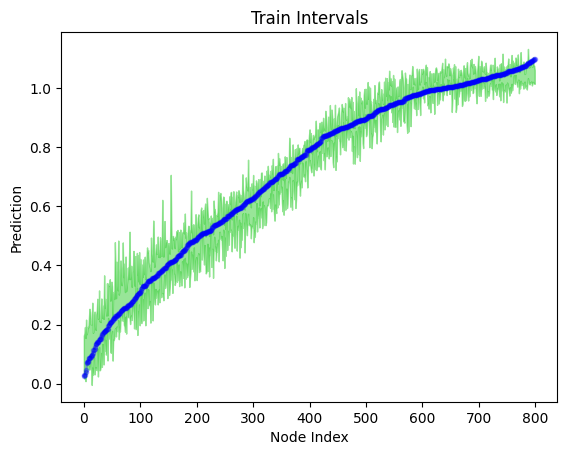

In [16]:
def to_numpy(tensor):
    """PyTorch Tensor → NumPy 변환 후 1차원으로 변형"""
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy().squeeze()
    elif isinstance(tensor, np.ndarray):
        return tensor.squeeze()
    else:
        raise TypeError(f"Unsupported data type: {type(tensor)}")
    
def sort_by_y(x, y, *intervals):
    sort_idx = np.argsort(to_numpy(y).ravel())  # Y값을 기준으로 정렬할 인덱스
    sorted_x = to_numpy(x).ravel()[sort_idx]
    sorted_y = to_numpy(y).ravel()[sort_idx]
    sorted_intervals = [to_numpy(interval).ravel()[sort_idx] for interval in intervals]
    return sorted_x, sorted_y, sorted_intervals

r_train_preds_low, r_train_preds_upper, r_train_target = test_all_gqnn(model_fixed_j, train_data_bs, tau_low=0.05, tau_upper=0.95)
evaluate_model_performance(r_train_preds_low, r_train_preds_upper, r_train_target)
tr_x_sorted, tr_y_sorted, (r_train_preds_low_st, r_train_preds_upper_st) = sort_by_y(train_data_bs.x, train_data_bs.y, r_train_preds_low, r_train_preds_upper)
plt.plot(range(len(train_data_bs.x)), tr_y_sorted, marker='.', alpha=0.3, color='blue', label="True Values")
plt.fill_between(range(len(train_data_bs.x)), r_train_preds_low_st, r_train_preds_upper_st, color='limegreen', alpha=0.5)
plt.title("Train Intervals")
plt.xlabel("Node Index")
plt.ylabel("Prediction")

In [182]:
print('-' * 100)
print('Fixed2 GQNN Training...')
model_fixed2_j = train_fixed2_gqnn(train_data_bs, q='all')
model_fixed2_sg = train_fixed2_gqnn(train_data_bs, q='single')

----------------------------------------------------------------------------------------------------
Fixed2 GQNN Training...
Epoch 0: Loss = 1.7462, Coverage Erro: 0.8100
Epoch 100: Loss = 0.7932, Coverage Erro: 0.5681
Epoch 200: Loss = 0.7522, Coverage Erro: 0.5366
Epoch 300: Loss = 0.6344, Coverage Erro: 0.4865
Epoch 400: Loss = 0.2739, Coverage Erro: 0.2364
Epoch 500: Loss = 0.2541, Coverage Erro: 0.2256
Epoch 600: Loss = 0.2861, Coverage Erro: 0.2614
Epoch 700: Loss = 0.3442, Coverage Erro: 0.3206
Epoch 800: Loss = 0.2246, Coverage Erro: 0.2025
Epoch 900: Loss = 0.2458, Coverage Erro: 0.2244
Epoch 0: Loss = 1.3146, Coverage Erro: 0.7014
Epoch 100: Loss = 0.5441, Coverage Erro: 0.3660
Epoch 200: Loss = 0.5385, Coverage Erro: 0.3736
Epoch 300: Loss = 0.3835, Coverage Erro: 0.2639
Epoch 400: Loss = 0.1889, Coverage Erro: 0.1287
Epoch 500: Loss = 0.1476, Coverage Erro: 0.1040
Epoch 600: Loss = 0.2660, Coverage Erro: 0.2256
Epoch 700: Loss = 0.1520, Coverage Erro: 0.1251
Epoch 800: Loss

In [12]:
# 학습 및 테스트 평가 
train_low_preds_dj, train_upper_preds_dj, train_target_dj = test_all_gqnn(model_fixed_j, train_data_bs, tau_low=0.05, tau_upper=0.95)
train_low_preds_dsg, _ = test_sg_gqnn(model_fixed_05, train_data_bs, tau =0.05)
train_upper_preds_dsg, train_target_dsg = test_sg_gqnn(model_fixed_95, train_data_bs, tau =0.95)

test_low_preds_dj, test_upper_preds_dj, test_target_dj = test_all_gqnn(model_fixed_j, test_data_bs, tau_low=0.05, tau_upper=0.95)
test_low_preds_dsg, _ = test_sg_gqnn(model_fixed_05, test_data_bs, tau =0.05)
test_upper_preds_dsg, test_target_dsg = test_sg_gqnn(model_fixed_95, test_data_bs, tau =0.95)

print('Fixed GQNN (Joint) Train Evaluating..')
evaluate_model_performance(train_low_preds_dj, train_upper_preds_dj, train_target_dj)
print('-' * 100)
print('Fixed GQNN (Joint) TestEvaluating..')
evaluate_model_performance(test_low_preds_dj, test_upper_preds_dj, test_target_dj)
print('-' * 100)
print('Fixed GQNN (Seperate) Train Evaluating..')
evaluate_model_performance(train_low_preds_dsg, train_upper_preds_dsg, train_target_dsg)
print('-' * 100)
print('Fixed GQNN (Seperate) Test Evaluating..')
evaluate_model_performance(test_low_preds_dsg, test_upper_preds_dsg, test_target_dsg)

Fixed GQNN (Joint) Train Evaluating..
   - Coverage Rate: 0.8263 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.1229
   - Mean Absolute Error (MAE): 0.0321
----------------------------------------------------------------------------------------------------
Fixed GQNN (Joint) TestEvaluating..
   - Coverage Rate: 0.8200 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.1136
   - Mean Absolute Error (MAE): 0.0309
----------------------------------------------------------------------------------------------------
Fixed GQNN (Seperate) Train Evaluating..
   - Coverage Rate: 0.8063 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.2662
   - Mean Absolute Error (MAE): 0.0887
----------------------------------------------------------------------------------------------------
Fixed GQNN (Seperate) Test Evaluating..
   - Coverage Rate: 0.8500 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.3599
   - Mean Absolute Error (MAE): 0.1014


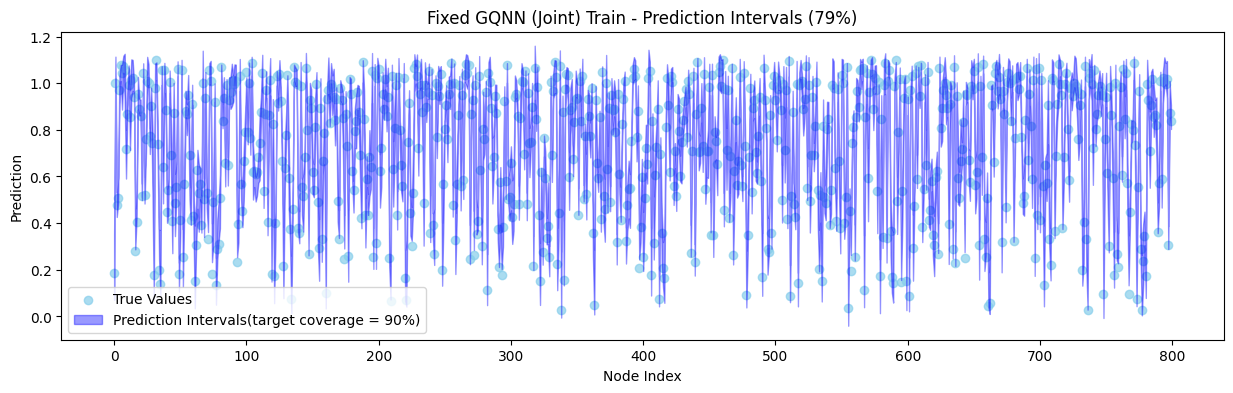

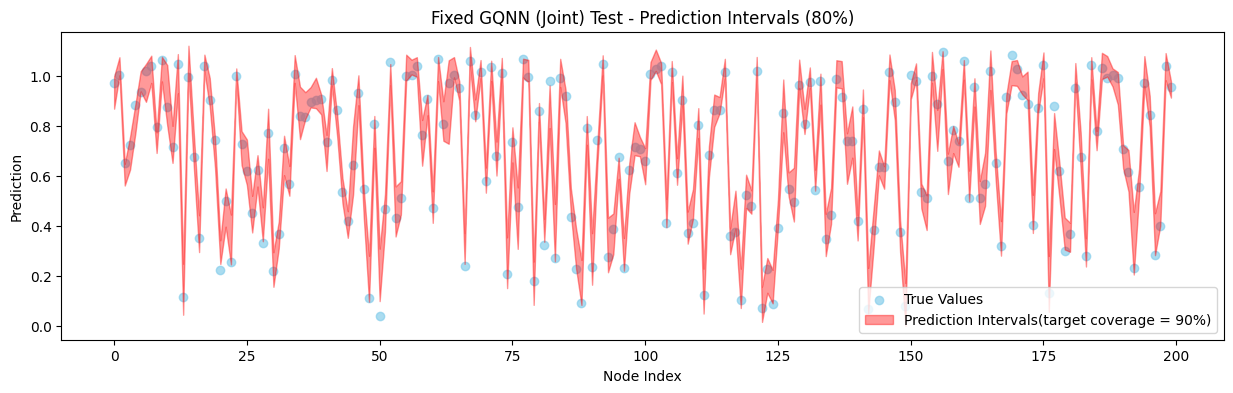

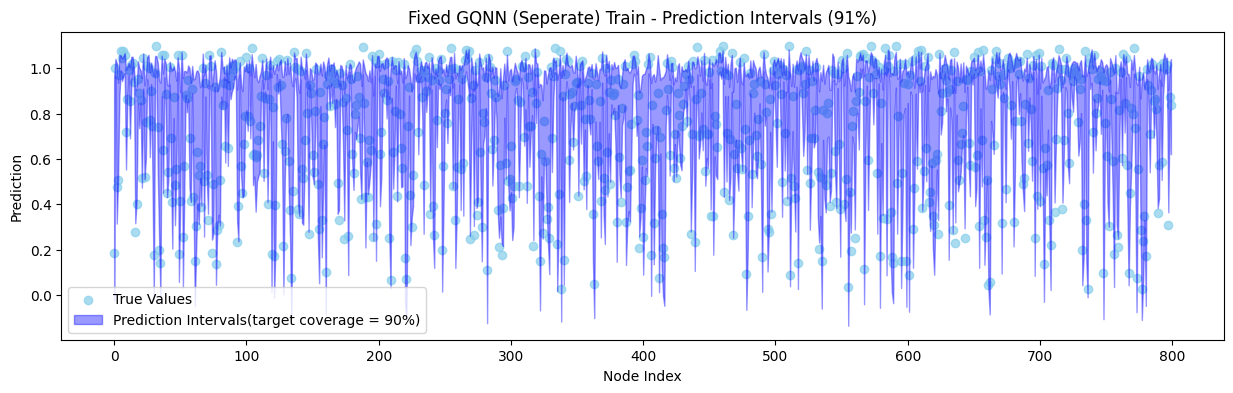

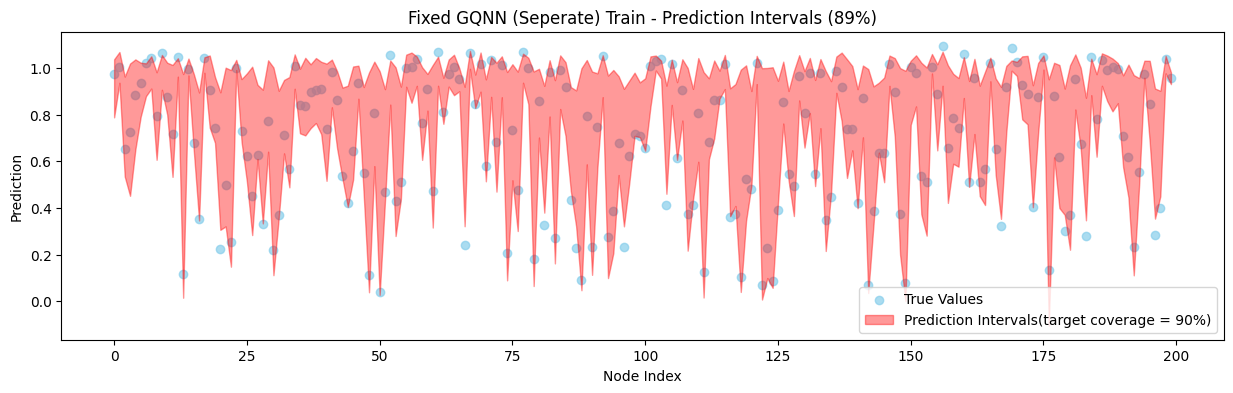

In [9]:
visualize_results(train_low_preds_dj, train_upper_preds_dj, train_target_dj, title = 'Fixed GQNN (Joint) Train - Prediction Intervals (79%)', color='blue')
visualize_results(test_low_preds_dj, test_upper_preds_dj, test_target_dj, title = 'Fixed GQNN (Joint) Test - Prediction Intervals (80%)', color='red')

visualize_results(train_low_preds_dsg, train_upper_preds_dsg, train_target_dsg, title = 'Fixed GQNN (Seperate) Train - Prediction Intervals (91%)', color='blue')
visualize_results(test_low_preds_dsg, test_upper_preds_dsg, test_target_dsg, title = 'Fixed GQNN (Seperate) Train - Prediction Intervals (89%)', color='red')

In [193]:
# 학습 및 테스트 평가 
train_low_preds_dj2, train_upper_preds_dj2, train_target_dj2 = test_all_gqnn(model_fixed2_j, train_data_bs, tau_low=0.05, tau_upper=0.95)
train_low_preds_ds2, train_upper_preds_ds2, train_target_ds2 = test_all_gqnn(model_fixed2_sg, train_data_bs, tau_low=0.05, tau_upper=0.95)

test_low_preds_dj2, test_upper_preds_dj2, test_target_dj2 = test_all_gqnn(model_fixed2_j, test_data_bs, tau_low=0.05, tau_upper=0.95)
test_low_preds_ds2, test_upper_preds_ds2, test_target_ds2 = test_all_gqnn(model_fixed2_sg, test_data_bs, tau_low=0.05, tau_upper=0.95)

print('Fixed2 GQNN (Joint) Train Evaluating..')
evaluate_model_performance(train_low_preds_dj2, train_upper_preds_dj2, train_target_dj2)
evaluate_intervals(train_low_preds_dj2, train_upper_preds_dj2, train_target_dj2)
print('-' * 100)
print('Fixed2 GQNN (Joint) TestEvaluating..')
evaluate_model_performance(test_low_preds_dj2, test_upper_preds_dj2, test_target_dj2)
evaluate_intervals(test_low_preds_dj2, test_upper_preds_dj2, test_target_dj2)
print('-' * 100)
print('Fixed2 GQNN (Seperate) Train Evaluating..')
evaluate_model_performance(train_low_preds_ds2, train_upper_preds_ds2, train_target_ds2)
evaluate_intervals(train_low_preds_ds2, train_upper_preds_ds2, train_target_ds2)
print('-' * 100)
print('Fixed2 GQNN (Seperate) Test Evaluating..')
evaluate_model_performance(test_low_preds_ds2, test_upper_preds_ds2, test_target_ds2)
evaluate_intervals(test_low_preds_ds2, test_upper_preds_ds2, test_target_ds2)

Fixed2 GQNN (Joint) Train Evaluating..
   - Coverage Rate: 0.6125 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.0628
   - Mean Absolute Error (MAE): 0.0263
Coverage (PICP): 0.6125
Mean Prediction Interval Width (MPIW): 0.0628
MCT (Coverage-Width Tradeoff): 0.0181
PINAW (Normalized Interval Width): 0.0585
----------------------------------------------------------------------------------------------------
Fixed2 GQNN (Joint) TestEvaluating..
   - Coverage Rate: 0.7100 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.0808
   - Mean Absolute Error (MAE): 0.0286
Coverage (PICP): 0.7100
Mean Prediction Interval Width (MPIW): 0.0808
MCT (Coverage-Width Tradeoff): 0.0154
PINAW (Normalized Interval Width): 0.0756
----------------------------------------------------------------------------------------------------
Fixed2 GQNN (Seperate) Train Evaluating..
   - Coverage Rate: 0.5413 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.0795
   - Mean Absolute Error (MAE): 0.0405
Coverage (PICP): 

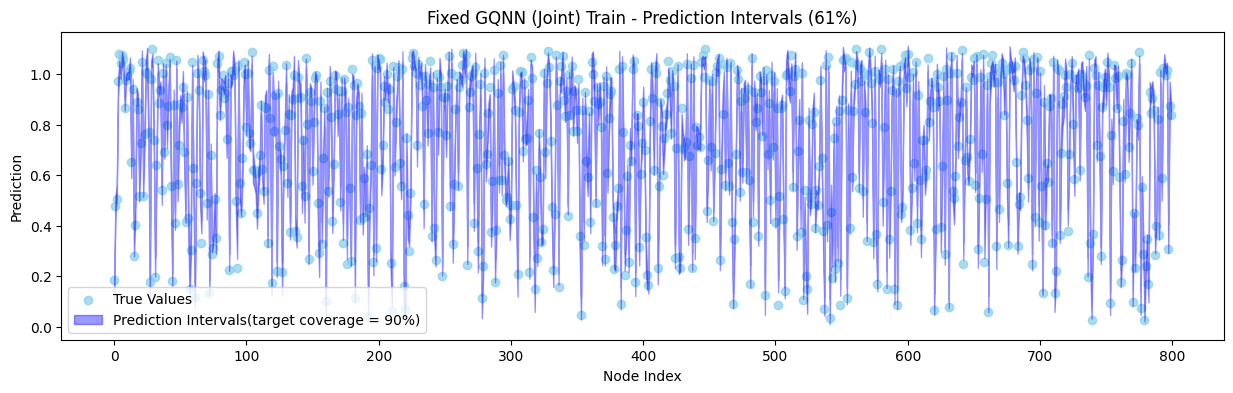

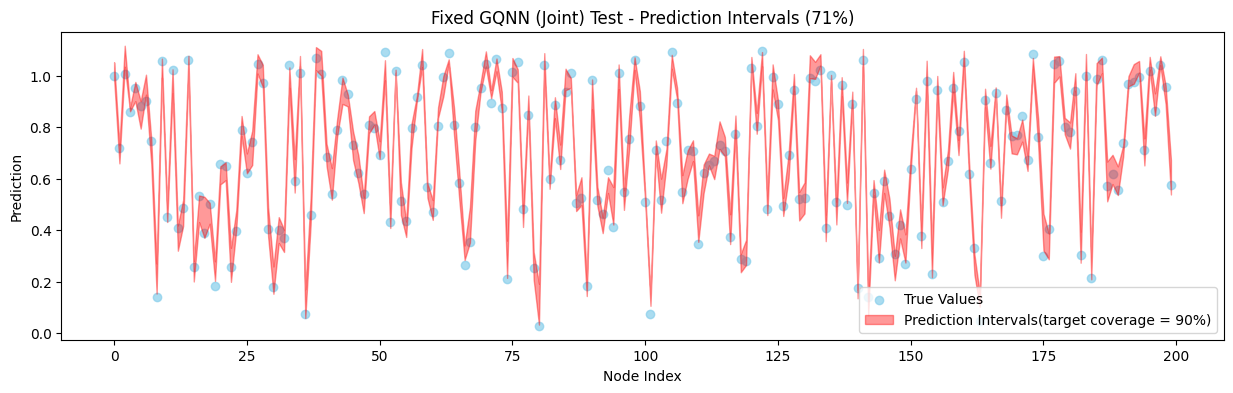

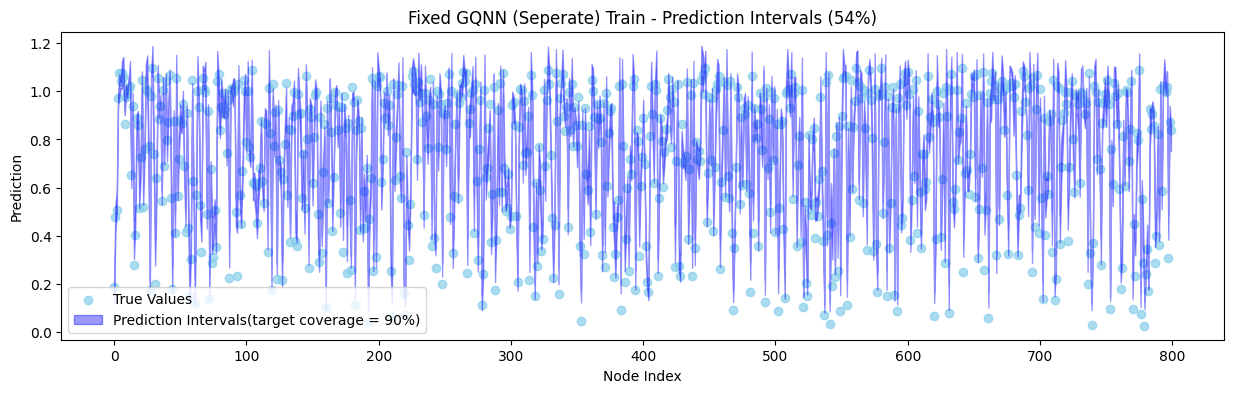

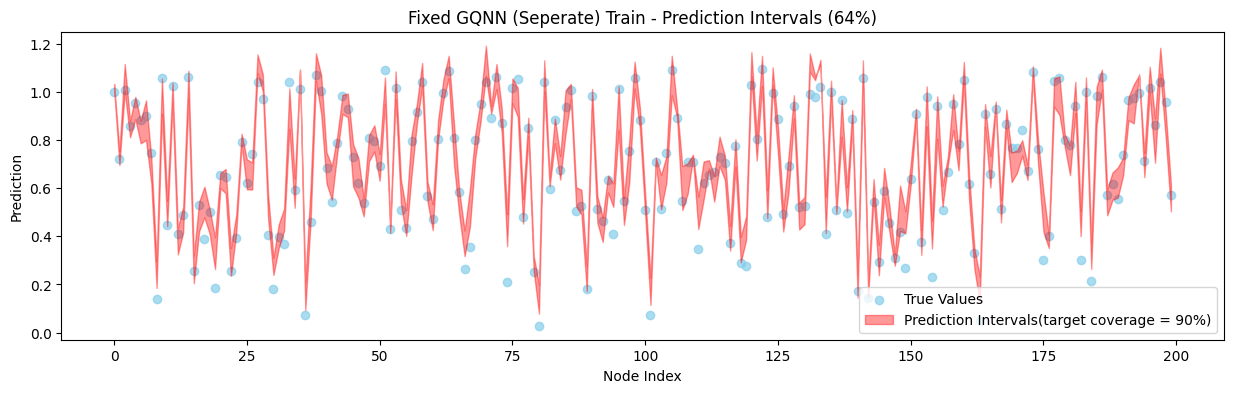

In [185]:
visualize_results(train_low_preds_dj2, train_upper_preds_dj2, train_target_dj2, title = 'Fixed GQNN (Joint) Train - Prediction Intervals (61%)', color='blue')
visualize_results(test_low_preds_dj2, test_upper_preds_dj2, test_target_dj2, title = 'Fixed GQNN (Joint) Test - Prediction Intervals (71%)', color='red')

visualize_results(train_low_preds_ds2, train_upper_preds_ds2, train_target_ds2, title = 'Fixed GQNN (Seperate) Train - Prediction Intervals (54%)', color='blue')
visualize_results(test_low_preds_ds2, test_upper_preds_ds2, test_target_ds2, title = 'Fixed GQNN (Seperate) Train - Prediction Intervals (64%)', color='red')

#### dynamic

In [143]:
print('-' * 100)
print('Dynamic GQNN Training...')
model_dynamic_all, tau_low_all, tau_upper_all = train_dynamic_gqnn(train_data_bs, q='all')
model_dynamic_single, tau_low_sg, tau_upper_sg = train_dynamic_gqnn(train_data_bs, q='single')

----------------------------------------------------------------------------------------------------
Dynamic GQNN Training...
Epoch 0: Loss = 0.8752, Coverage Error: 0.9000, Taus: (0.060000000000000005, 0.94)
Epoch 100: Loss = 0.2437, Coverage Error: 0.7975, Taus: (0.4084919146816926, 0.5915080853183072)


KeyboardInterrupt: 

In [128]:
# 학습 및 테스트 평가 
train_low_preds_dj, _ = test_sg_gqnn(model_dynamic_all, train_data_bs, tau=tau_low_all)
train_upper_preds_dj, train_target_dj = test_sg_gqnn(model_dynamic_single, train_data_bs, tau=tau_upper_all)
train_low_preds_dsg, _ = test_sg_gqnn(model_dynamic_single, train_data_bs, tau=tau_low_sg)
train_upper_preds_dsg, train_target_dsg = test_sg_gqnn(model_dynamic_single, train_data_bs, tau=tau_upper_sg)

test_low_preds_dj, _ = test_sg_gqnn(model_dynamic_all, test_data_bs, tau=tau_low_all)
test_upper_preds_dj, test_target_dj = test_sg_gqnn(model_dynamic_single, test_data_bs, tau=tau_upper_all)
test_low_preds_dsg, _ = test_sg_gqnn(model_dynamic_single, test_data_bs, tau=tau_low_sg)
test_upper_preds_dsg, test_target_dsg = test_sg_gqnn(model_dynamic_single, test_data_bs, tau=tau_upper_sg)

print('Dynamic GQNN (Joint) Train Evaluating..')
evaluate_model_performance(train_low_preds_dj, train_upper_preds_dj, train_target_dj)
print('-' * 100)
print('Dynamic GQNN (Joint) TestEvaluating..')
evaluate_model_performance(test_low_preds_dj, test_upper_preds_dj, test_target_dj)
print('-' * 100)
print('Dynamic GQNN (Seperate) Train Evaluating..')
evaluate_model_performance(train_low_preds_dsg, train_upper_preds_dsg, train_target_dsg)
print('-' * 100)
print('Dynamic GQNN (Seperate) Test Evaluating..')
evaluate_model_performance(test_low_preds_dsg, test_upper_preds_dsg, test_target_dsg)

Dynamic GQNN (Joint) Train Evaluating..
   - Coverage Rate: 0.2075 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.0109
   - Mean Absolute Error (MAE): 0.0187
----------------------------------------------------------------------------------------------------
Dynamic GQNN (Joint) TestEvaluating..
   - Coverage Rate: 0.1150 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.0052
   - Mean Absolute Error (MAE): 0.0329
----------------------------------------------------------------------------------------------------
Dynamic GQNN (Seperate) Train Evaluating..
   - Coverage Rate: 0.0712 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.0034
   - Mean Absolute Error (MAE): 0.0218
----------------------------------------------------------------------------------------------------
Dynamic GQNN (Seperate) Test Evaluating..
   - Coverage Rate: 0.0400 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.0001
   - Mean Absolute Error (MAE): 0.0336


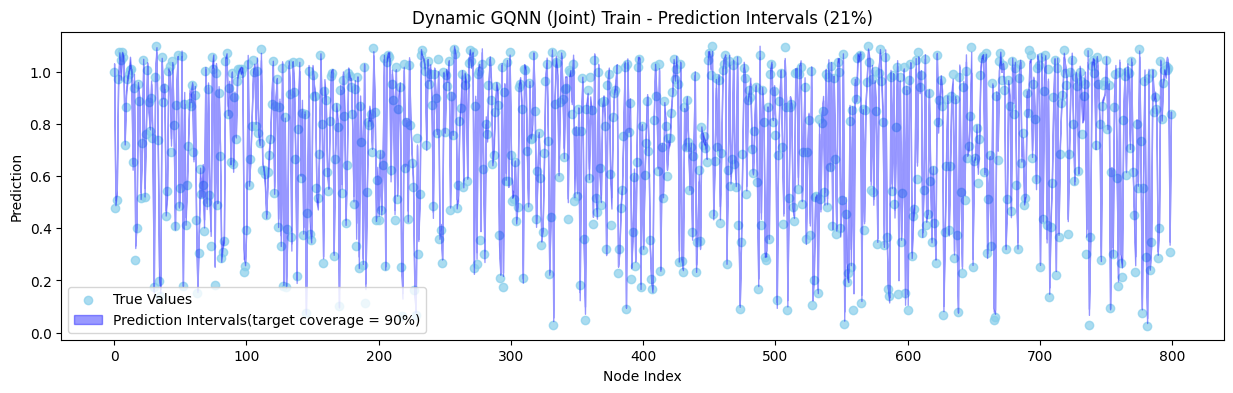

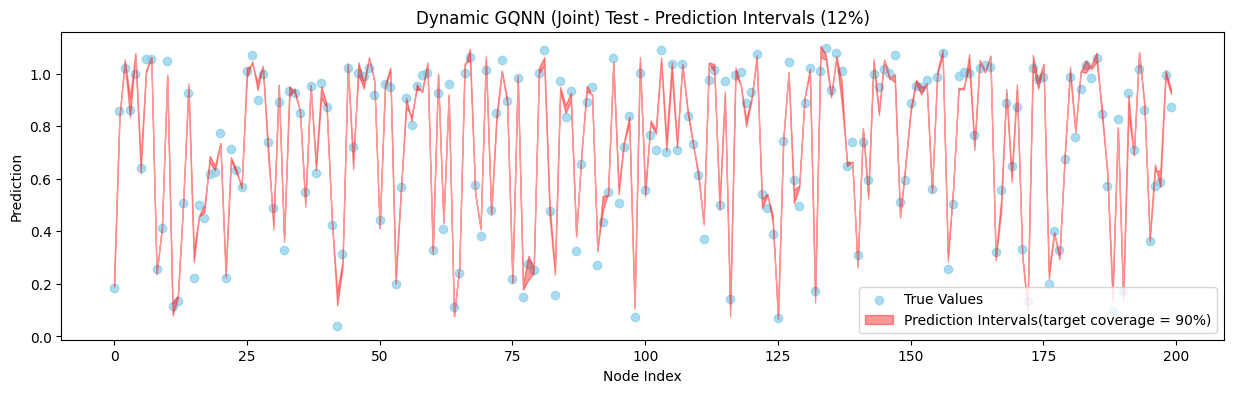

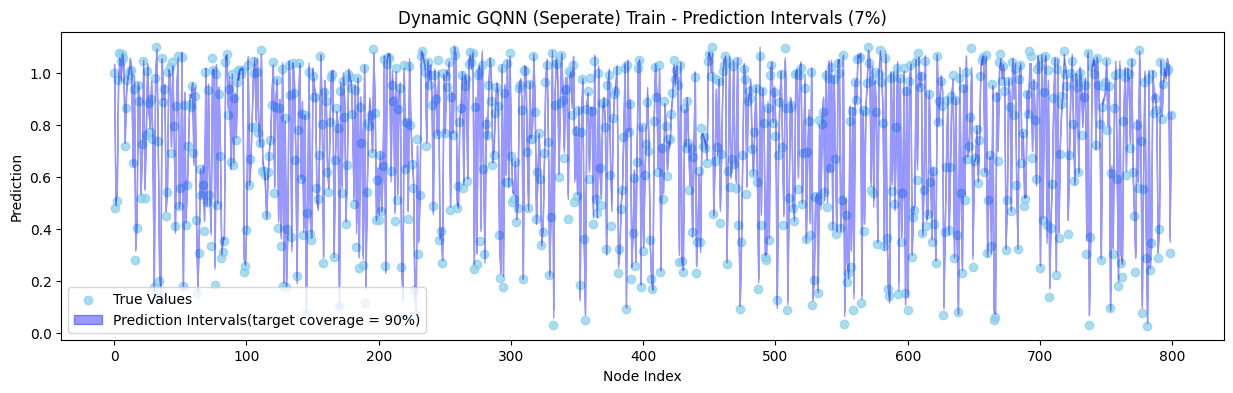

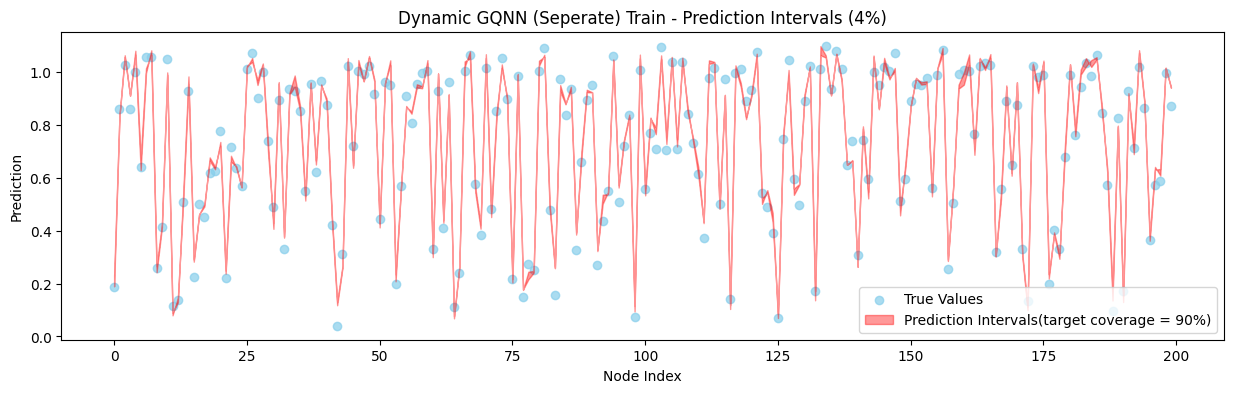

In [129]:
visualize_results(train_low_preds_dj, train_upper_preds_dj, train_target_dj, title = 'Dynamic GQNN (Joint) Train - Prediction Intervals (21%)', color='blue')
visualize_results(test_low_preds_dj, test_upper_preds_dj, test_target_dj, title = 'Dynamic GQNN (Joint) Test - Prediction Intervals (12%)', color='red')

visualize_results(train_low_preds_dsg, train_upper_preds_dsg, train_target_dsg, title = 'Dynamic GQNN (Seperate) Train - Prediction Intervals (7%)', color='blue')
visualize_results(test_low_preds_dsg, test_upper_preds_dsg, test_target_dsg, title = 'Dynamic GQNN (Seperate) Train - Prediction Intervals (4%)', color='red')

#### RQR

In [186]:
print('-' * 100)
print('RQR GQNN Training...')
model_rqr = train_rqr_gqnn(train_data_bs)

----------------------------------------------------------------------------------------------------
RQR GQNN Training...
Epoch 0: Loss = 1.3706
Epoch 100: Loss = 0.0558
Epoch 200: Loss = 0.0521
Epoch 300: Loss = 0.0518
Epoch 400: Loss = 0.0515
Epoch 500: Loss = 0.0513
Epoch 600: Loss = 0.0518
Epoch 700: Loss = 0.0513
Epoch 800: Loss = 0.0518
Epoch 900: Loss = 0.0519


In [192]:
# 학습 및 테스트 평가 
train_low_preds_rqr, train_upper_preds_rqr, train_target_rqr = test_rqr_gqnn(model_rqr, train_data_bs)
test_low_preds_rqr, test_upper_preds_rqr, test_target_rqr = test_rqr_gqnn(model_rqr, test_data_bs)

print('RQR GNN Train Evaluating..')
evaluate_model_performance(train_low_preds_rqr, train_upper_preds_rqr, train_target_rqr)
evaluate_intervals(train_low_preds_rqr, train_upper_preds_rqr, train_target_rqr)
print('-' * 100)
print('RQR GQNN Test Evaluating..')
evaluate_model_performance(test_low_preds_rqr, test_upper_preds_rqr, test_target_rqr)
evaluate_intervals(test_low_preds_rqr, test_upper_preds_rqr, test_target_rqr)

RQR GNN Train Evaluating..
   - Coverage Rate: 0.7997 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.7836
   - Mean Absolute Error (MAE): 0.2727
Coverage (PICP): 0.7997
Mean Prediction Interval Width (MPIW): 0.7836
MCT (Coverage-Width Tradeoff): 0.0786
PINAW (Normalized Interval Width): 0.7306
----------------------------------------------------------------------------------------------------
RQR GQNN Test Evaluating..
   - Coverage Rate: 0.8235 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.7837
   - Mean Absolute Error (MAE): 0.2445
Coverage (PICP): 0.8235
Mean Prediction Interval Width (MPIW): 0.7837
MCT (Coverage-Width Tradeoff): 0.0599
PINAW (Normalized Interval Width): 0.7334


In [ ]:
visualize_results(train_low_preds_rqr, train_upper_preds_rqr, train_target_rqr, title = 'RQR GNN Train - Prediction Intervals (80%)', color='blue')
visualize_results(test_low_preds_rqr, test_upper_preds_rqr, test_target_rqr, title = 'RQR GNN Test - Prediction Intervals (79%)', color='red')

In [156]:
print('-' * 100)
print('Combined RQR GQNN Training...')
model_crqr = train_combined_rqr_gqnn(train_data_bs)

----------------------------------------------------------------------------------------------------
Combined RQR GQNN Training...
Epoch 0: Loss = 0.6117
Epoch 100: Loss = 0.0867
Epoch 200: Loss = 0.0811
Epoch 300: Loss = 0.0809
Epoch 400: Loss = 0.0808
Epoch 500: Loss = 0.0808
Epoch 600: Loss = 0.0808
Epoch 700: Loss = 0.0807
Epoch 800: Loss = 0.0808
Epoch 900: Loss = 0.0807


In [157]:
# 학습 및 테스트 평가 
train_low_preds_crqr, train_upper_preds_crqr, train_target_crqr = test_rqr_gqnn(model_crqr, train_data_bs)
test_low_preds_crqr, test_upper_preds_crqr, test_target_crqr = test_rqr_gqnn(model_crqr, test_data_bs)

print('crqr GNN Train Evaluating..')
evaluate_model_performance(train_low_preds_crqr, train_upper_preds_crqr, train_target_crqr)
print('-' * 100)
print('crqr GQNN Test Evaluating..')
evaluate_model_performance(test_low_preds_crqr, test_upper_preds_crqr, test_target_crqr)

crqr GNN Train Evaluating..
   - Coverage Rate: 0.7572 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.7233
   - Mean Absolute Error (MAE): 0.2585
----------------------------------------------------------------------------------------------------
crqr GQNN Test Evaluating..
   - Coverage Rate: 0.7701 (목표: 0.9)
   - Prediction Interval Width (PIW): 0.7218
   - Mean Absolute Error (MAE): 0.2715


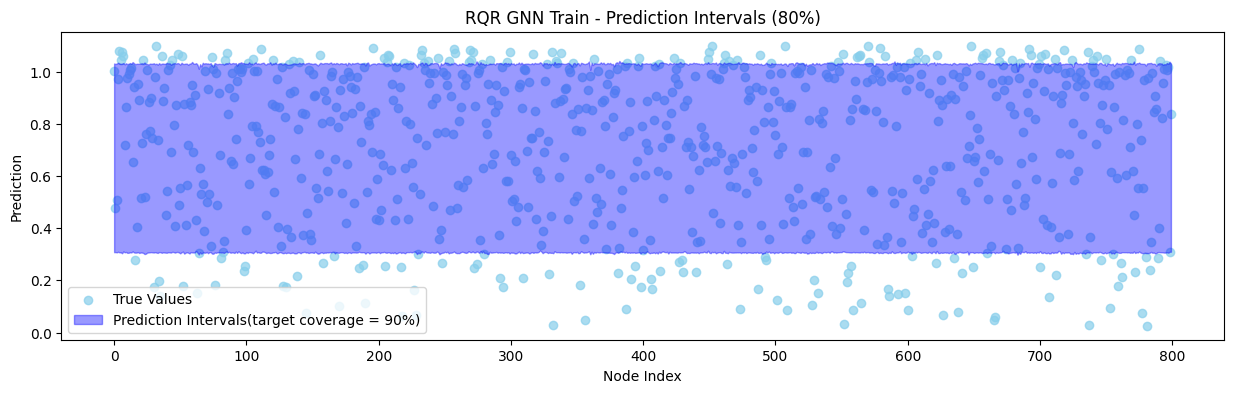

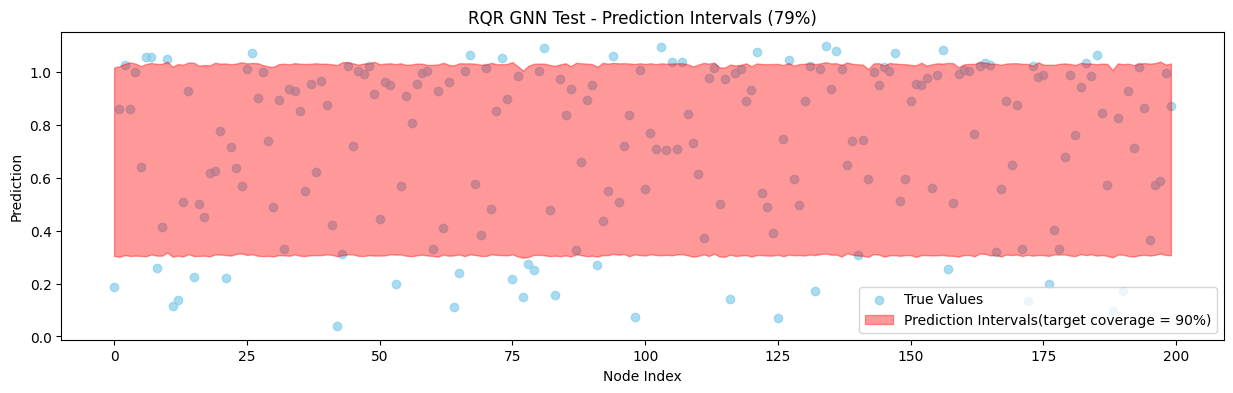

In [158]:
visualize_results(train_low_preds_crqr, train_upper_preds_crqr, train_target_crqr, title = 'RQR GNN Train - Prediction Intervals (80%)', color='blue')
visualize_results(test_low_preds_crqr, test_upper_preds_crqr, test_target_crqr, title = 'RQR GNN Test - Prediction Intervals (79%)', color='red')